#  INTENT 3: 
# Smart Meters in London: Data Analysis and ML model (Part 2/2)

This jupyter notebook wants to analyse the data coming from the energy consumption of different users, to see how a forecast algorithm can be developed, or clustering models can be done. 

The structure of this notebook is as follows: 

Analysis of different household, according to different types of tariffs, to see whether there are different patterns. 


In [1]:
# Importing libraries required for the analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
from sqlalchemy import create_engine 
import os
import sklearn 

# Importing libraries required for T-S analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import lag_plot
import itertools

# Seting style for matplotlib
plt.style.use('ggplot')

In [41]:
# Reading the current working directoy to see where are we writing the code. 
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/your-project/2.JupyterNotebooks'

In [42]:
# Seeing all the files we have in clean_data folder 
os.listdir('../0.Data/clean_data')

['halfhourly_block12_cleaned.csv',
 'MAC000291_cleaned_consumption.csv',
 'info_househoulds_cleaned.csv',
 'weather_hourly_cleaned.csv']

In [43]:
users_info = pd.read_csv('../0.Data/clean_data/info_househoulds_cleaned.csv', index_col=0)

In [44]:
users_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [45]:
users_info.columns = ['LCLid', 'tariff', 'acorn_class', 'acorn_group', 'file']

In [46]:
users_info['tariff'].value_counts()

Std    4443
ToU    1123
Name: tariff, dtype: int64

Text(0.5, 0, 'Type of tariff')

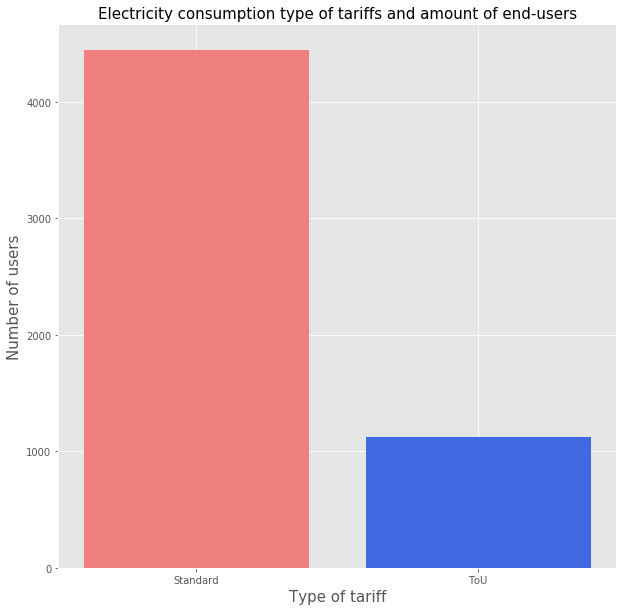

In [47]:
plt.figure(figsize=(10,10))
plt.bar(x=['Standard','ToU'], height=users_info['tariff'].value_counts(), color=['lightcoral', 'royalblue'])
plt.title("Electricity consumption type of tariffs and amount of end-users", fontsize=15)
plt.ylabel("Number of users", fontsize=15)
plt.xlabel('Type of tariff', fontsize=15)

As we can see from the graph above, there are two different types of tariff that the user can contract: **Standard** and **ToU**. Also we can see that there is a huge tendency on the amount of users to have a Standard contract instead of a ToU contract. 


We will choose two end-users with a Standard Tariff contracted and later on we will choose two end-users with a ToU tariff, to see whether there are significant differences in the model. 

In [48]:
users_info[(users_info['tariff']=='ToU') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
600,MAC005106,ToU,ACORN-D,Affluent,block_12
604,MAC005179,ToU,ACORN-D,Affluent,block_12
610,MAC001495,ToU,ACORN-D,Affluent,block_12
611,MAC002622,ToU,ACORN-D,Affluent,block_12
613,MAC002645,ToU,ACORN-D,Affluent,block_12


In [49]:
users_info[(users_info['tariff']=='Std') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
601,MAC004340,Std,ACORN-D,Affluent,block_12
602,MAC002137,Std,ACORN-D,Affluent,block_12
603,MAC001800,Std,ACORN-D,Affluent,block_12
605,MAC005182,Std,ACORN-D,Affluent,block_12
606,MAC004280,Std,ACORN-D,Affluent,block_12


We will use the data coming from two users with ToU Tariff and two with Std Tariff that they are also in block_12 since it is the block that we have cleaned before. We will import block_12 to analyse these data. 

`ToU users`: MAC001495 and MAC002645

`Standard users`: MAC001800 and MAC004280

In [38]:
half_hourly_df = pd.read_csv('../0.Data/clean_data/halfhourly_block12_cleaned.csv', index_col=0)

In [39]:
half_hourly_df.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


## Standard Users